=== Assumptions ===
Hyperliquid taker fee : 0.0150%
Lighter taker fee     : 0.0000%
Round-trip fee        : 0.0300%
Expected holding      : 60 h
Funding interval      : 1 h
Safety multiplier     : x1.1
=> Global min funding edge / period: 0.0006%

====================== BTC ======================
Long HL / Short Lighter: no instance of positive edge.
Direction: Long Lighter / Short HL
  Number of positive edge points      : 3269
  Median edge (positive only)         : 0.0012%
  75th percentile edge                : 0.0012%
  90th percentile edge                : 0.0012%
  %% of positive edge > global_min_edge: 98.2%%
  Recommended min edge for token      : 0.0012%


====================== ETH ======================
Long HL / Short Lighter: no instance of positive edge.
Direction: Long Lighter / Short HL
  Number of positive edge points      : 3269
  Median edge (positive only)         : 0.0012%
  75th percentile edge                : 0.0012%
  90th percentile edge                : 0.00

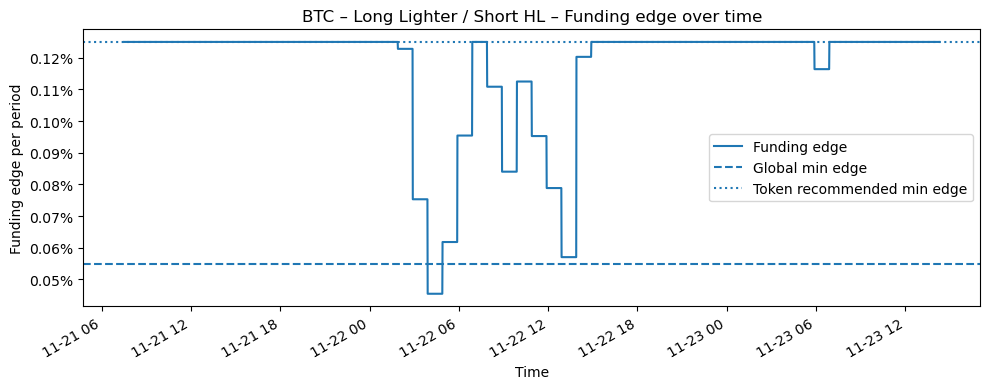

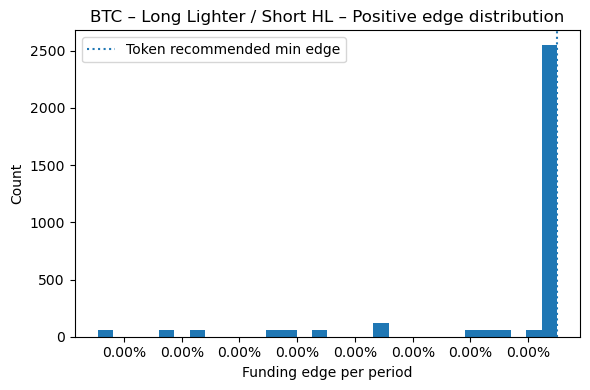

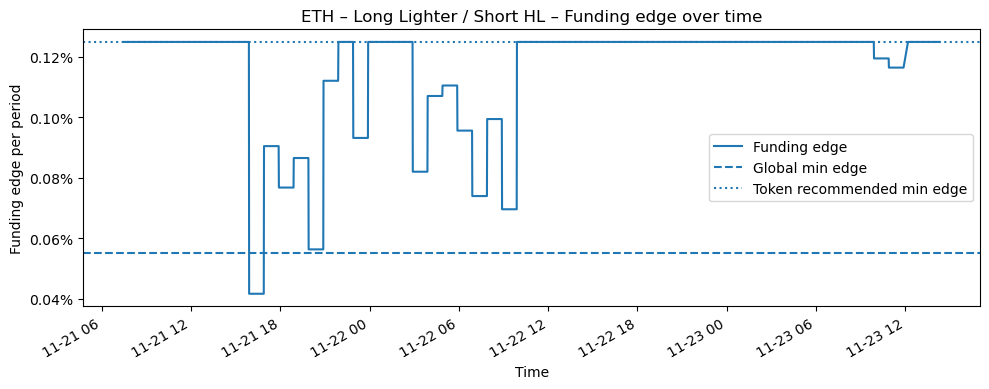

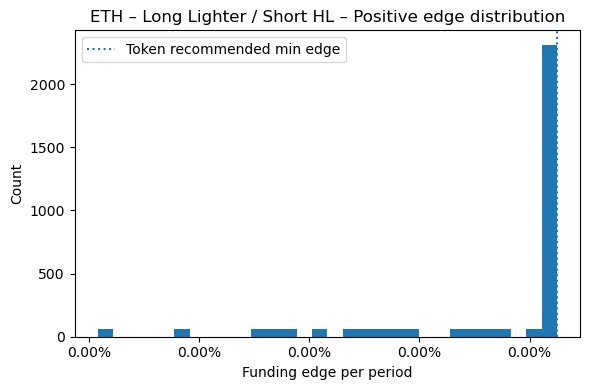

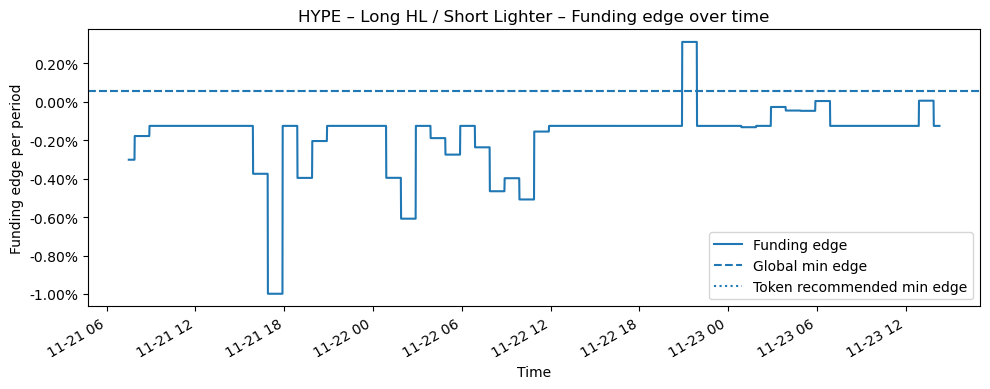

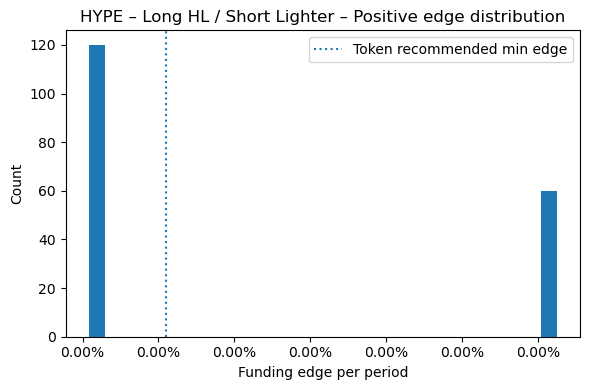

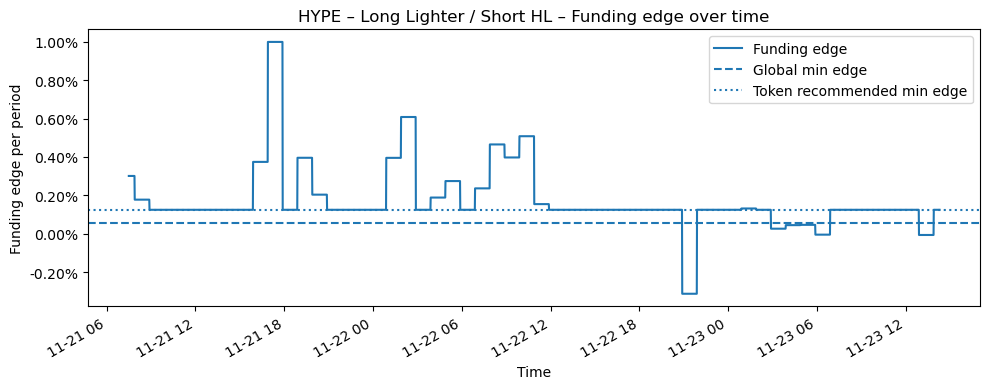

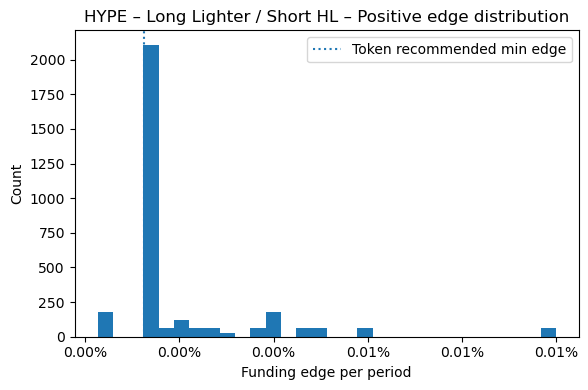

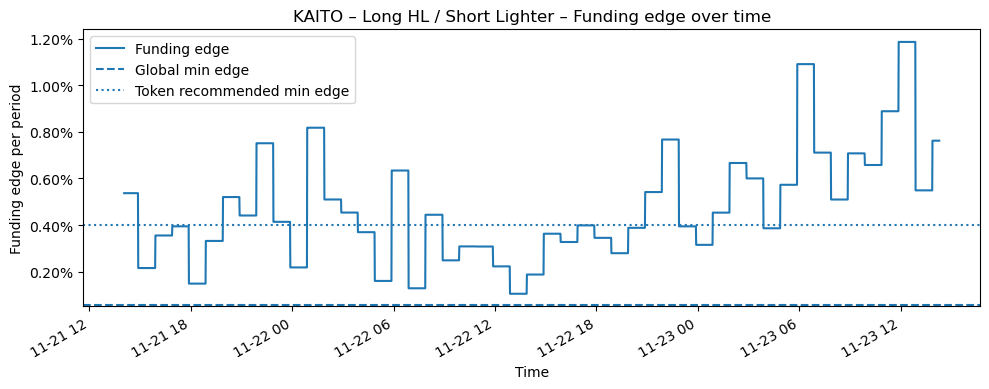

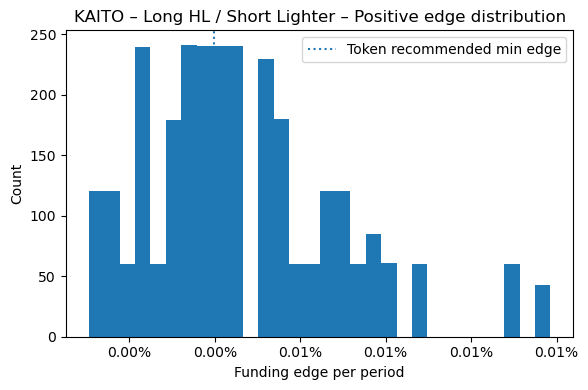

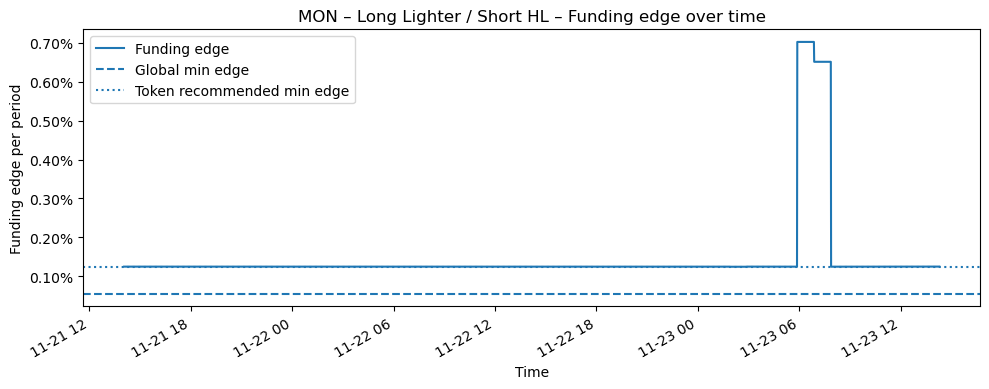

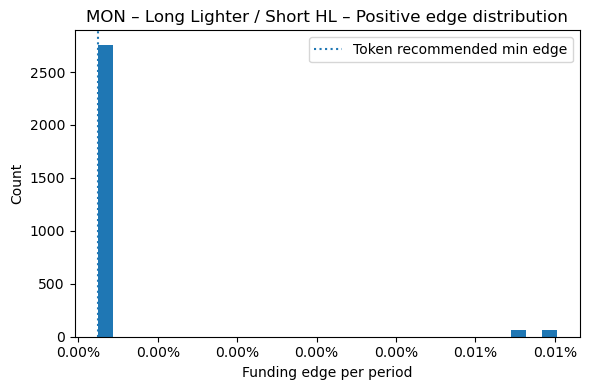

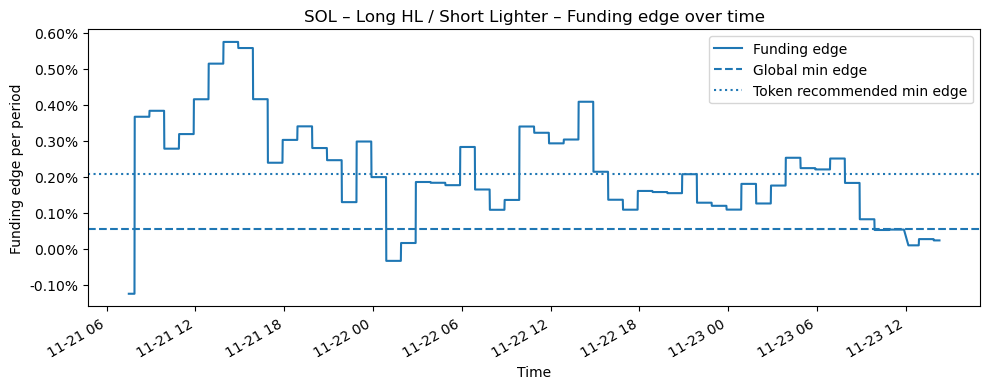

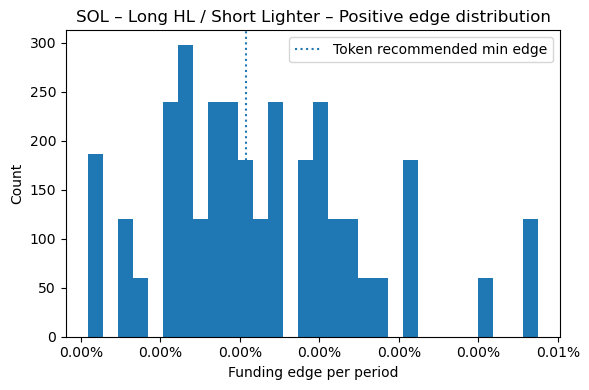

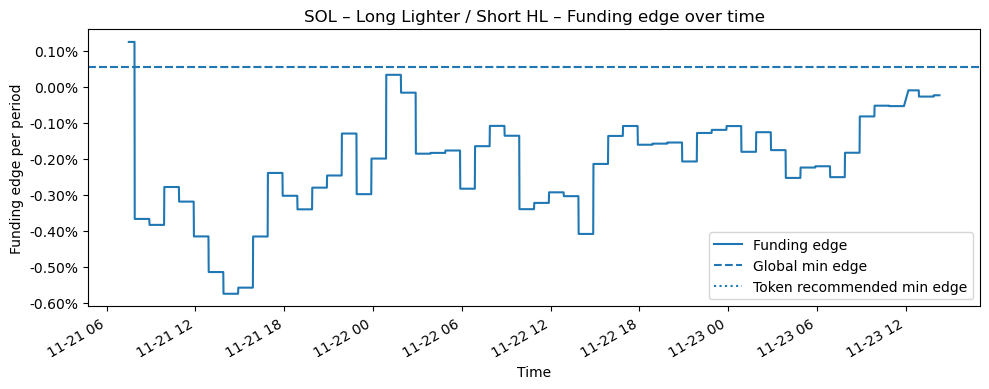

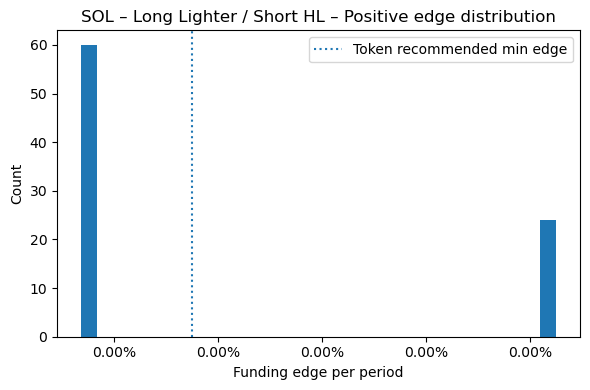

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# =========================
# 1. Load all CSVs in a folder
# =========================

def load_funding_files(folder_path: str) -> pd.DataFrame:
    """
    Read all *_funding_rates.csv files in a folder.
    Each file has columns:
        - timestamp
        - hyperliquid_funding_rate
        - lighter_funding_rate
    The token name is extracted from file prefix, for example: BTC_2025-11-09_funding_rates.csv -> BTC
    """
    folder = Path(folder_path)
    data_frames = []

    for path in folder.glob("*_funding_rates.csv"):
        token = path.name.split("_")[0]  # BTC / ETH / SOL / HYPE...
        df = pd.read_csv(path, parse_dates=["timestamp"])
        df["token"] = token
        data_frames.append(df)

    if not data_frames:
        raise ValueError(f"No *_funding_rates.csv files found in {folder_path}")

    return pd.concat(data_frames, ignore_index=True)


# =========================
# 2. Compute funding edge for both directions
# =========================

def add_funding_edges(df: pd.DataFrame) -> pd.DataFrame:
    """
    Assumption: funding_rate > 0 means LONG pays SHORT (normal for perps).
    Therefore:
      - Long HL, Short Lighter:
            net_edge = funding_short_Lighter + funding_long_HL
                     = lighter_funding_rate - hyperliquid_funding_rate
      - Long Lighter, Short HL: reverse.
    lighter_funding_rate is in %, so divide by 100.
    """
    df = df.copy()
    hl = df["hyperliquid_funding_rate"]      # already decimal
    lg = df["lighter_funding_rate"] / 100.0  # convert from % to decimal

    # Long Hyperliquid, Short Lighter
    df["edge_long_hl_short_lighter"] = lg - hl

    # Long Lighter, Short Hyperliquid
    df["edge_long_lighter_short_hl"] = -df["edge_long_hl_short_lighter"]

    return df


# =========================
# 3. Analyze min funding edge (global + per token)
# =========================

def analyze_min_funding_edge(
    df: pd.DataFrame,
    taker_fee_hl: float = 0.00015,      # 0.015% per trade on Hyperliquid
    taker_fee_lighter: float = 0.0,     # 0 for Lighter (market maker)
    expected_holding_hours: float = 24,  # expected to hold e.g. 8h
    funding_period_hours: float = 1,    # funding in CSV is every 1h
    safety_mult: float = 1.1         # buffer > fee, e.g. 1.5x
):
    """
    Calculate min funding edge per period required so that:
        edge * num_periods_hold > round_trip_fees * safety_mult

    - round_trip_fees = 2 * (fee HL + fee Lighter)  # open + close, both exchanges
    - min_edge_per_period = round_trip_fees * safety_mult / holding_periods

    Returns:
      - df_edges: dataframe with edge columns
      - summary: per token + direction summary table
      - min_edge_per_period: global threshold from fees
    """

    df_edges = add_funding_edges(df)

    # Total round-trip fee (open + close on both exchanges)
    fee_round_trip = 2 * (taker_fee_hl + taker_fee_lighter)

    # Expected number of funding periods to hold position
    holding_periods = expected_holding_hours / funding_period_hours

    # Min funding edge per period needed to overcome fees (with buffer)
    min_edge_per_period = fee_round_trip * safety_mult / holding_periods

    print("=== Assumptions ===")
    print(f"Hyperliquid taker fee : {taker_fee_hl:.4%}")
    print(f"Lighter taker fee     : {taker_fee_lighter:.4%}")
    print(f"Round-trip fee        : {fee_round_trip:.4%}")
    print(f"Expected holding      : {expected_holding_hours} h")
    print(f"Funding interval      : {funding_period_hours} h")
    print(f"Safety multiplier     : x{safety_mult}")
    print(f"=> Global min funding edge / period: {min_edge_per_period:.4%}\n")

    directions = [
        ("edge_long_hl_short_lighter", "Long HL / Short Lighter"),
        ("edge_long_lighter_short_hl", "Long Lighter / Short HL"),
    ]

    rows = []

    for token, g in df_edges.groupby("token"):
        print(f"====================== {token} ======================")
        for col, label in directions:
            edges = g[col].dropna()

            # Only consider times when edge > 0 (i.e., that direction has positive funding edge)
            pos_edges = edges[edges > 0]
            if pos_edges.empty:
                print(f"{label}: no instance of positive edge.")
                continue

            pct_above = (pos_edges > min_edge_per_period).mean() * 100

            median_edge = pos_edges.median()
            p75 = pos_edges.quantile(0.75)
            p90 = pos_edges.quantile(0.90)

            # recommended_min_edge_token:
            # take max(global_min_edge, median positive edge) -> distinct threshold for token
            recommended_min_edge = max(min_edge_per_period, median_edge)

            print(f"Direction: {label}")
            print(f"  Number of positive edge points      : {len(pos_edges)}")
            print(f"  Median edge (positive only)         : {median_edge:.4%}")
            print(f"  75th percentile edge                : {p75:.4%}")
            print(f"  90th percentile edge                : {p90:.4%}")
            print(f"  %% of positive edge > global_min_edge: {pct_above:.1f}%%")
            print(f"  Recommended min edge for token      : {recommended_min_edge:.4%}\n")

            rows.append({
                "token": token,
                "direction": label,
                "global_min_edge": min_edge_per_period,
                "median_edge_pos": median_edge,
                "p75_edge_pos": p75,
                "p90_edge_pos": p90,
                "pct_above_global_min": pct_above,
                "recommended_min_edge": recommended_min_edge,
            })

        print()

    summary = pd.DataFrame(rows)
    return df_edges, summary, min_edge_per_period


# =========================
# 4. Plot illustrations
# =========================

def _percent_formatter(x, pos):
    """Format y-axis as prettier percentage."""
    return f"{x * 100:.2f}%"

def plot_funding_edges(
    df_edges: pd.DataFrame,
    summary: pd.DataFrame,
    global_min_edge: float,
    output_dir: str | None = None,
):
    """
    Plot:
      1) Time series of funding edge for each token + direction,
         with lines for global_min_edge and recommended_min_edge.
      2) Histogram of positive edge values for each token + direction,
         with a line for recommended_min_edge.
    """
    if output_dir is not None:
        out_path = Path(output_dir)
        out_path.mkdir(parents=True, exist_ok=True)
    else:
        out_path = None

    directions = [
        ("edge_long_hl_short_lighter", "Long HL / Short Lighter"),
        ("edge_long_lighter_short_hl", "Long Lighter / Short HL"),
    ]

    # Loop over every token and direction
    for (token, label_row) in summary[["token", "direction"]].drop_duplicates().itertuples(index=False):
        g = df_edges[df_edges["token"] == token].copy()

        # get the matching summary row
        row = summary[(summary["token"] == token) & (summary["direction"] == label_row)]
        if row.empty:
            continue
        rec_min_edge = float(row["recommended_min_edge"].iloc[0])

        # map direction label to column name
        if label_row == "Long HL / Short Lighter":
            col = "edge_long_hl_short_lighter"
        else:
            col = "edge_long_lighter_short_hl"

        edges = g[[ "timestamp", col ]].dropna()
        if edges.empty:
            continue

        # --- 4.1 Time series plot ---
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(edges["timestamp"], edges[col]*100, label="Funding edge")
        ax.axhline(global_min_edge*100, linestyle="--",color = "red", label="Global min edge")
        ax.axhline(rec_min_edge*100, linestyle=":", color = "blue", label="Token recommended min edge")
        ax.set_title(f"{token} – {label_row} – Funding edge over time")
        ax.set_xlabel("Time")
        ax.set_ylabel("Funding edge per period")
        ax.yaxis.set_major_formatter(FuncFormatter(_percent_formatter))
        ax.legend()
        fig.autofmt_xdate()
        plt.tight_layout()

        if out_path is not None:
            fname = out_path / f"{token}_{col}_timeseries.png"
            plt.savefig(fname, dpi=150)
        # If running in notebook/script, still show the plot
        plt.show()

        # --- 4.2 Histogram plot ---
        pos_edges = edges[col][edges[col] > 0]
        if not pos_edges.empty:
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.hist(pos_edges, bins=30)
            ax.axvline(rec_min_edge, linestyle=":", label="Token recommended min edge")
            ax.set_title(f"{token} – {label_row} – Positive edge distribution")
            ax.set_xlabel("Funding edge per period")
            ax.set_ylabel("Count")
            ax.xaxis.set_major_formatter(FuncFormatter(_percent_formatter))
            ax.legend()
            plt.tight_layout()

            if out_path is not None:
                fname = out_path / f"{token}_{col}_hist.png"
                plt.savefig(fname, dpi=150)
            plt.show()


# =========================
# 5. Example usage
# =========================

if __name__ == "__main__":
    folder = "/Users/trancatkhanh/Downloads/Monitor PNL/funding_rates_v3"  # change to your path
    df_raw = load_funding_files(folder)

    df_edges, summary, global_min_edge = analyze_min_funding_edge(
        df_raw,
        taker_fee_hl=0.00015,        # 0.015% (update to your actual fee)
        taker_fee_lighter=0.0,       # 0 if you are MM on Lighter
        expected_holding_hours=60,    # expected average holding period in hours
        funding_period_hours=1,      # CSV reports every hour
        safety_mult=1.1             # want edge > 1.5 * fee
    )

    # Print summary table of min edge for each token
    print("\n===== SUMMARY TABLE =====")
    print(summary.to_string(index=False))

    # Plot illustration (optionally pass output_dir to save files)
    plot_funding_edges(df_edges, summary, global_min_edge, output_dir=None)

In [ ]:
0.000056

In [14]:
1.25e-05-1.1999999999999999e-05

5.00000000000002e-07

6e-06